In [1]:
#!ls -al /content/drive/MyDrive/lab4
!nvidia-smi

Mon May 17 08:30:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary

from matplotlib import pyplot as plt
from scipy.io import loadmat
import math, sys, os, time
import pandas as pd
import numpy as np

DATASET_DIR = "/content/drive/MyDrive/AE-4-EEG-Artifact-Removal/BCICIV2a/"
BASE_DIR = "/content/drive/MyDrive/lab4/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch shape: (batch_size, chan (depth), h, w)

In [3]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [ ]:
class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        # input_size: 1 x EEG channel x datapoint
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        # by setting the convolutional kernel being (1,lenght) and the strids being 1 we can use conv2d to
        # achieve the 1d convolution operation
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1),
                                         int(self.pool*0.25))
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 2)
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        size = self.get_size(input_size)
        self.fc = nn.Sequential(
            nn.Linear(size[1], hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)

        out = self.BN_s(out_)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

    def get_size(self, input_size):
        # here we use an array with the shape being
        # (1(mini-batch),1(convolutional channel),EEG channel,time data point)
        # to simulate the input data and get the output size
        data = torch.ones((1, input_size[0], input_size[1], int(input_size[2])))
        y = self.Tception1(data)
        out = y
        y = self.Tception2(data)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(data)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_final = z
        z = self.Sception2(out)
        out_final = torch.cat((out_final, z), dim=2)
        out = self.BN_s(out_final)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        return out.size()

In [71]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if (not (ep % 10)) or (ep == 1):
                print(f"Epoch {ep}/{epochs}")
            self.model.train()
            step = 1
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                pred = self.model(x_batch)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if (not (ep % 10)) or (ep == 1):
                    pbar = int(step * 30 / len(trainloader))
                    print("\r{}/{} [{}{}]".format(
                        step, len(trainloader), ">" * pbar, " " * (30 - pbar)), 
                        end="")
                step += 1
            # evaluate
            loss, acc = self.evaluate(trainloader)
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # dump message
            if (not (ep % 10)) or (ep == 1):
                print(" {:.4f}s - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}".format(
                    time.time()-proc_start, history["loss"][-1], 
                    history["acc"][-1], history["val_loss"][-1], history["val_acc"][-1])
                )
            # model check point
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                if not os.path.exists("./model"):
                    os.mkdir("./model")
                print(f"save model/checkpoint_model_ep-{ep}.pt")
                self.save(f"model/checkpoint_model_ep-{ep}.pt")
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
        return history
    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()
        acc /= total

        return (loss, acc)
    def predict(self, dataloader):
        prediction = []
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch).cpu()
            prediction = np.append(prediction, pred.argmax(dim=1).numpy())
        return prediction
    def save(self, filepath):
        torch.save(self.model, filepath)
    @classmethod
    def load(cls, filepath):
        return cls(torch.load(filepath))
    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] < evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] > evaluation[1]:
                    return False # present epoch acc < history acc
                elif _ == "val_loss" and pre_ck_point[2] < evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] > evaluation[3]:
                    return False # present epoch val_acc < history val_acc        
        return True

In [105]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1,2,3], [0,1,2,3], rotation=45)
    plt.yticks([0,1,2,3], [0,1,2,3])

    thresh = conf_matrix.max() / 2.
    for i in range(4):
        for j in range(4):
            plt.text(j, i, format(conf_matrix[i, j], "d"), 
                horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("Real label")
    plt.xlabel("Pred label")
    plt.show()

#Part 1

## Problem 1

In [63]:
!ls -al model

total 8
drwxr-xr-x 2 root root 4096 May 17 09:11 .
drwxr-xr-x 1 root root 4096 May 17 08:31 ..


In [64]:
BATCH_SIZE = 32
Learning_Rate = 0.001
EPOCHS = 500

In [65]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]

In [66]:
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

""" create dataloader """
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([288, 1, 22, 562]) torch.Size([288])
torch.Size([288, 1, 22, 562]) torch.Size([288])


Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2288s - loss: 1.3899 - acc: 0.2639 - val_loss: 1.3846 - val_acc: 0.2604
save model/checkpoint_model_ep-1.pt
save model/checkpoint_model_ep-2.pt
save model/checkpoint_model_ep-3.pt
save model/checkpoint_model_ep-4.pt
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2025s - loss: 1.0417 - acc: 0.5556 - val_loss: 1.0327 - val_acc: 0.4757
save model/checkpoint_model_ep-10.pt
save model/checkpoint_model_ep-11.pt
save model/checkpoint_model_ep-12.pt
save model/checkpoint_model_ep-14.pt
save model/checkpoint_model_ep-15.pt
save model/checkpoint_model_ep-16.pt
save model/checkpoint_model_ep-17.pt
save model/checkpoint_model_ep-18.pt
save model/checkpoint_model_ep-19.pt
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2027s - loss: 0.7286 - acc: 0.7569 - val_loss: 0.8603 - val_acc: 0.6701
save model/checkpoint_model_ep-20.pt
save model/checkpoint_model_ep-22.pt
save model/checkpoint_model_ep-23.pt
save model/checkpoint_model_ep-27.pt
save

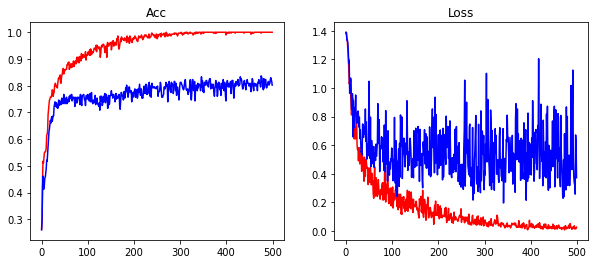

In [67]:
eegnet = EEGNet().to(device)
#summary(eegnet, (1, 22, 562))
model = Model(eegnet, lr=Learning_Rate)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=EPOCHS, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

### (a)

In [68]:
# load model
ld_model = Model.load("model/checkpoint_model_ep-477.pt")
eva_train = ld_model.evaluate(dataloader=trainloader)
print(f"Train Accuracy: {eva_train[1]:.4f}\tTrain Loss: {eva_train[0]:.4f}")
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")

Train Accuracy: 1.0000	Train Loss: 0.0144
Test Accuracy: 0.8333	Test Loss: 0.1194


### (b)

In [107]:
rec_train = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
# confusion matrix in (c)
conf_matrix_train = np.zeros(shape=(4, 4), dtype="uint8")
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_train = trY.reshape(trY.size)
real_test = teY.reshape(teY.size)
# Warning: close shuffle first before predict
pred_train = ld_model.predict(dataloader=DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=False)).astype("uint8")
pred_test = ld_model.predict(dataloader=DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)).astype("uint8")

for i in range(288):
    rec_train["total"][real_train[i]] += 1
    rec_train["hit"][real_train[i]] += (1 if real_train[i] == pred_train[i] else 0)
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)

    conf_matrix_train[real_train[i]][pred_train[i]] += 1
    conf_matrix_test[real_test[i]][pred_test[i]] += 1

In [108]:
for i in range(4):
    print("Train accuracy of class-{}: {}".format(i, rec_train["hit"][i] / rec_train["total"][i]))
print()
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Train accuracy of class-0: 1.0
Train accuracy of class-1: 1.0
Train accuracy of class-2: 1.0
Train accuracy of class-3: 1.0

Test accuracy of class-0: 0.9444444444444444
Test accuracy of class-1: 0.9027777777777778
Test accuracy of class-2: 0.7222222222222222
Test accuracy of class-3: 0.7638888888888888


### (c)

[[72  0  0  0]
 [ 0 72  0  0]
 [ 0  0 72  0]
 [ 0  0  0 72]]


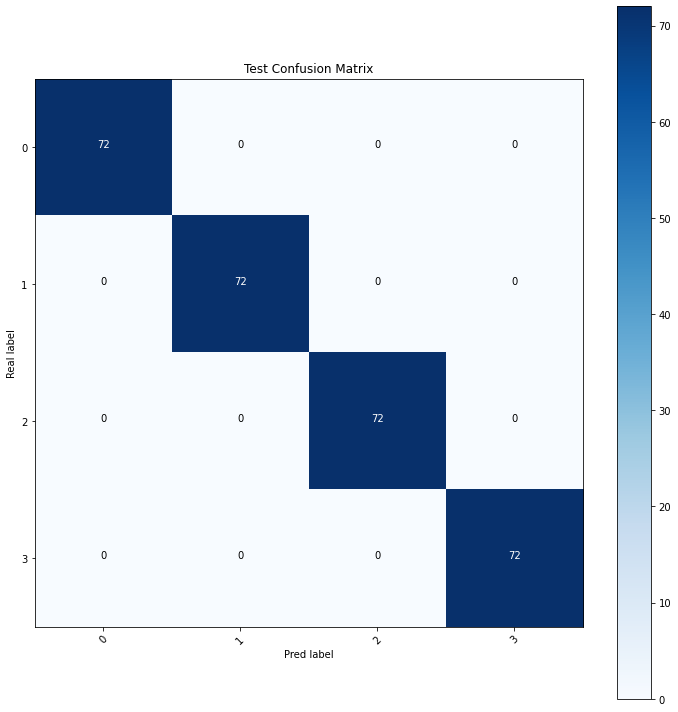

In [109]:
print(conf_matrix_train)
plot_confusion_matrix(conf_matrix_train, "Train Confusion Matrix")

[[68  2  2  0]
 [ 5 65  2  0]
 [ 5  1 52 14]
 [ 1  0 16 55]]


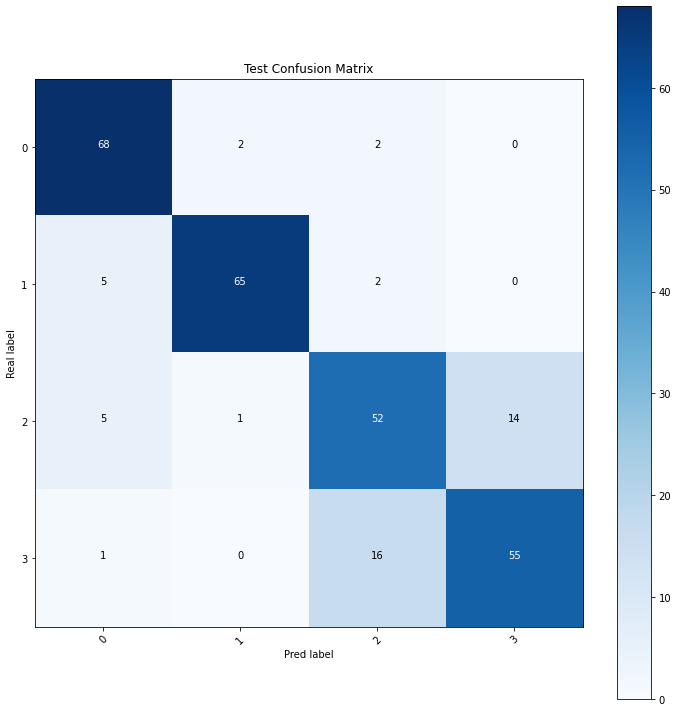

In [110]:
print(conf_matrix_test)
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")